## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/User/Downloads/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [7]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [8]:
print(loss)

2.3277617232130603


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

The weights now are random, which means that we are completely guessing, and the probability to guess the correct class is $\frac{1}{10}$. Therefore,
$$
loss = -log(prob) = -log(\frac{1}{10}) \approx 2.3
$$

#### Softmax gradient

In [13]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -1.705580 analytic: -1.705580, relative error: 2.436825e-08
numerical: -0.157223 analytic: -0.157223, relative error: 4.659767e-08
numerical: -1.805484 analytic: -1.805484, relative error: 3.360091e-08
numerical: 2.519739 analytic: 2.519739, relative error: 3.287539e-09
numerical: 0.231455 analytic: 0.231455, relative error: 1.966572e-07
numerical: -0.623176 analytic: -0.623176, relative error: 4.133681e-08
numerical: -5.853168 analytic: -5.853168, relative error: 1.466608e-08
numerical: -0.798221 analytic: -0.798221, relative error: 3.293398e-08
numerical: 1.536596 analytic: 1.536596, relative error: 9.634465e-09
numerical: 0.764248 analytic: 0.764248, relative error: 9.603545e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [14]:
import time

In [18]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.344276534278497 / 346.9564647952164 computed in 0.04252910614013672s
Vectorized loss / grad: 2.344276534278496 / 346.95646479521645 computed in 0.003735065460205078s
difference in loss / grad: 8.881784197001252e-16 / 3.296434621252134e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.2772430369483616
iteration 100 / 1500: loss 2.141637928005332
iteration 200 / 1500: loss 1.9582393595036864
iteration 300 / 1500: loss 1.9792666727643415
iteration 400 / 1500: loss 1.8794272468555067
iteration 500 / 1500: loss 1.7522433065115737
iteration 600 / 1500: loss 1.8225245055546038
iteration 700 / 1500: loss 1.8470975672824008
iteration 800 / 1500: loss 1.764253713616652
iteration 900 / 1500: loss 1.8369729549856817
iteration 1000 / 1500: loss 1.9299233434401715
iteration 1100 / 1500: loss 1.8353088626234801
iteration 1200 / 1500: loss 1.7138162775982226
iteration 1300 / 1500: loss 1.8326974366177384
iteration 1400 / 1500: loss 1.8593940605836385
That took 8.937635898590088s


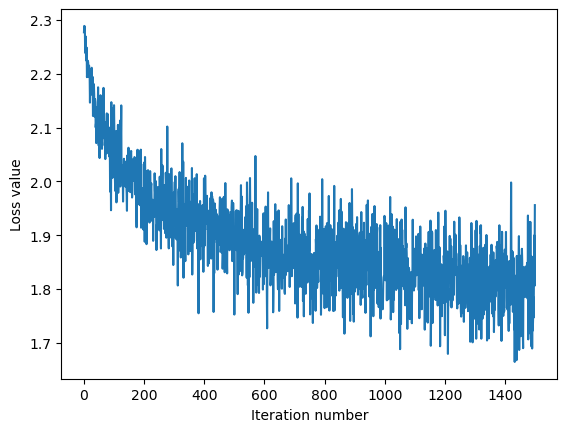

In [19]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [21]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3825918367346939
validation accuracy: 0.405


## Optimize the softmax classifier

In [ ]:
np.finfo(float).eps

In [26]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
best_rate = 0
best_val_acc = 0
cor_train_acc = 0
best_softmax = None
best_train_pred = None
best_val_pred = None
best_rate_loss_hist = None
best_test_acc = 0
for rate in learning_rates:
    loss_hist = softmax.train(X_train, y_train, learning_rate=rate, num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    train_acc = np.mean(np.equal(y_train, y_train_pred))
    y_val_pred = softmax.predict(X_val)
    val_acc = np.mean(np.equal(y_val, y_val_pred))
    if val_acc > best_val_acc:
        best_rate = rate
        best_val_acc = val_acc
        best_softmax = softmax
        best_val_pred = y_val_pred
        best_rate_loss_hist = loss_hist
        best_test_acc = np.mean(np.equal(y_test, softmax.predict(X_test)))
        cor_train_acc = train_acc
print("Best learning rate: ", best_rate)
print("Corresponding training accuracy: ", train_acc)
print("Best validation accuracy: ", best_val_acc)
print("Test accuracy: ", best_test_acc)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Best learning rate:  1e-06
Corresponding training accuracy:  0.3504897959183673
Best validation accuracy:  0.414
Test accuracy:  0.399
